In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt



In [2]:
def generate_cluster_data(num_points, mean, cov):
    """
    Generates integer data points for a single cluster following a Gaussian distribution.
    
    Parameters:
    num_points (int): Number of data points to generate for the cluster.
    mean (list of float): Mean of the Gaussian distribution [mean_x, mean_y].
    cov (list of list of float): Covariance matrix of the Gaussian distribution [[var_x, cov_xy], [cov_xy, var_y]].
    
    Returns:
    np.ndarray: A 2D array of shape (num_points, 2) containing the generated integer data points.
    """
    data = np.random.multivariate_normal(mean, cov, num_points)
    return np.floor(data).astype(int)  # Use np.ceil() for rounding up

def generate_custom_clusters(cluster_params):
    """
    Generates multiple clusters based on custom means and covariances.
    
    Parameters:
    cluster_params (list of tuples): A list where each tuple contains:
        - num_points (int): Number of data points in the cluster.
        - mean (list of float): Mean of the Gaussian distribution [mean_x, mean_y].
        - cov (list of list of float): Covariance matrix of the Gaussian distribution [[var_x, cov_xy], [cov_xy, var_y]].
    
    Returns:
    np.ndarray: A 2D array containing the generated data points from all clusters.
    list: A list of the optimal potentials for each cluster.
    """
    clusters = []
    labels = []
    optimal_potentials = []
    
    for i, (num_points, mean, cov) in enumerate(cluster_params):
        cluster_data = generate_cluster_data(num_points, mean, cov)
        clusters.append(cluster_data)
        
        # Assign a label to each point in this cluster
        labels.extend([i] * num_points)
        
        # Compute the optimal potential for this cluster
        optimal_potential = np.sum((cluster_data - mean) ** 2)
        optimal_potentials.append(optimal_potential)
    
    return np.vstack(clusters), np.array(labels), optimal_potentials


In [3]:

def initialize_centroids(data, k):
    n_samples, _ = data.shape
    centroids = []
    centroids.append(data[random.randint(0, n_samples - 1)])

    for _ in range(1, k):
        distances = np.array([min([np.linalg.norm(x - c) ** 2 for c in centroids]) for x in data])
        probabilities = distances / distances.sum()
        cumulative_probabilities = probabilities.cumsum()
        r = random.random()

        for j, p in enumerate(cumulative_probabilities):
            if r < p:
                centroids.append(data[j])
                break

    return np.array(centroids)

def assign_clusters(data, centroids):
    return np.array([np.argmin([np.linalg.norm(x - c) for c in centroids]) for x in data])

def update_centroids(data, labels, k):
    return np.array([data[labels == i].mean(axis=0) for i in range(k)])

def compute_potential(data, labels, centroids):
    potential = 0.0
    for i, centroid in enumerate(centroids):
        potential += np.sum((data[labels == i] - centroid) ** 2)
    return potential

def kmeans_plus_plus_iteration(data, k, max_iters=10, tolerance=1e-4):
    centroids = initialize_centroids(data, k)
    labels = assign_clusters(data, centroids)
    initial_potential = compute_potential(data, labels, centroids)
    
    for _ in range(max_iters):
        new_centroids = update_centroids(data, labels, k)
        new_labels = assign_clusters(data, new_centroids)

        if np.all(np.abs(new_centroids - centroids) < tolerance):
            break

        centroids = new_centroids
        labels = new_labels

    final_potential = compute_potential(data, labels, centroids)
    return initial_potential, final_potential

def run_experiments(data, k, num_experiments):
    initial_potentials = []
    final_potentials = []

    for _ in range(num_experiments):
        initial_potential, final_potential = kmeans_plus_plus_iteration(data, k)
        initial_potentials.append(initial_potential)
        final_potentials.append(final_potential)

    return initial_potentials, final_potentials

# Example usage:1M
##num_points = 10000
##mean = [0, 0]
##cov = [[50, 0.5], [0.5, 50]]
##data = np.random.multivariate_normal(mean, cov, num_points)

#k = 5
#num_experiments = 2**k

#initial_potentials, final_potentials = run_experiments(data, k, num_experiments)

#print("Initial Potentials:", initial_potentials)
#print("Final Potentials:", final_potentials)


1. 半径足够小，opt 算几何中心 对比
2. 逐渐提升半径
3。 2^k: 前 x 次平均 potential 与新的差 3sigma

In [27]:
# Define custom means and covariances for each cluster
cluster_params = [
    (10000, [20000, 20000], [[5000000000, 0], [0, 5000000000]]),  # Cluster 1
    (10000, [30000, 30000], [[7000000000, 0], [0, 7000000000]]),  # Cluster 2, closer to Cluster 1
    (10000, [40000, 20000], [[6000000000, 0], [0, 6000000000]]),  # Cluster 3, close to Cluster 1 and 2
    (10000, [50000, 30000], [[5000000000, 0], [0, 5000000000]]),  # Cluster 4, overlaps with Cluster 2 and 3
    (10000, [60000, 20000], [[5000000000, 0], [0, 5000000000]])   # Cluster 5, overlaps with Cluster 4
]

# Generate the custom clusters and compute the optimal potentials
data, labels, optimal_potentials = generate_custom_clusters(cluster_params)

# Sum of optimal potentials as the baseline
optimal_potential_baseline = sum(optimal_potentials)
print("Optimal Potential Baseline:", optimal_potential_baseline)

Optimal Potential Baseline: 49804569686107


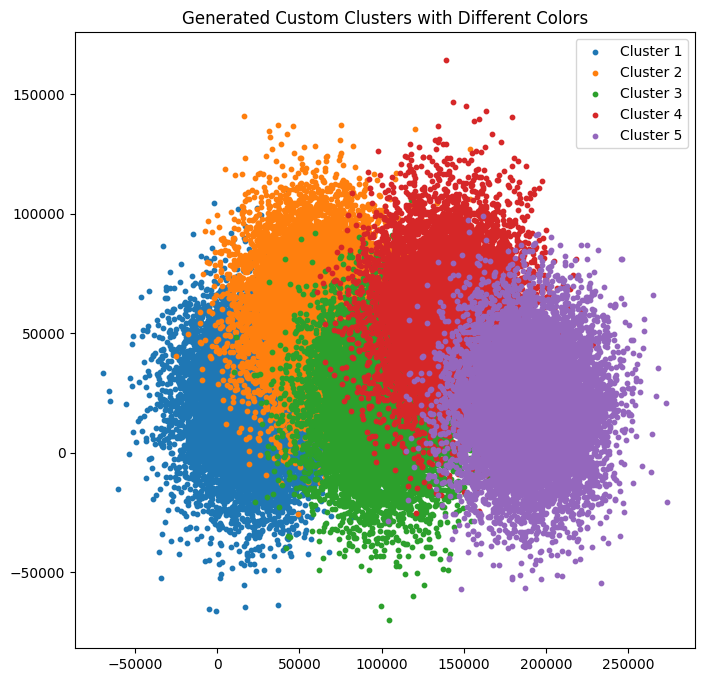

In [29]:
# Visualization with different colors for each cluster

k = len(cluster_params)
plt.figure(figsize=(8, 8))
for i in range(k):
    cluster_data = data[labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=10, label=f'Cluster {i+1}')
plt.title("Generated Custom Clusters with Different Colors")
plt.legend()
plt.show()

Final Potentials: [np.float64(38903714220060.086), np.float64(38879348194058.0), np.float64(38923437649388.84), np.float64(38879536650137.16), np.float64(38879496790402.33), np.float64(38889544807204.51), np.float64(38881614861301.12), np.float64(38879250099378.766), np.float64(38879359896441.516), np.float64(38898438190920.4), np.float64(38879437086548.47), np.float64(38891988411042.58), np.float64(38897103325208.125), np.float64(38879503245004.734), np.float64(38921636550963.49), np.float64(39002035978568.05), np.float64(39169966040065.77), np.float64(38880027373304.164), np.float64(38879291425639.234), np.float64(38880804291829.61), np.float64(47728375045190.39), np.float64(38879622497732.03), np.float64(39009580971794.43), np.float64(38880288277697.11), np.float64(41558647136401.19), np.float64(38879205458292.45), np.float64(38880144918710.27), np.float64(38880132978806.76), np.float64(50535845550571.53), np.float64(38936152146645.41), np.float64(38879239260985.195), np.float64(388

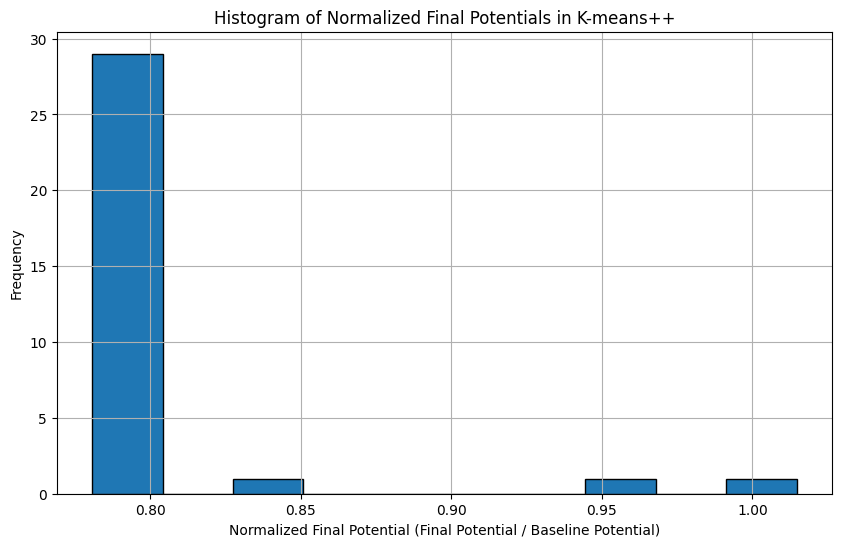

In [30]:
# Run K-means++ experiments
num_experiments = 2**k

initial_potentials, final_potentials = run_experiments(data, k, num_experiments)

print("Final Potentials:", final_potentials)

divided_OPT_pot = [fp / optimal_potential_baseline for fp in final_potentials]

print("Normalized Final Potentials:", divided_OPT_pot)

# Plot histogram of normalized final potentials
plt.figure(figsize=(10, 6))
plt.hist(divided_OPT_pot, bins=10, edgecolor='black')
plt.xlabel("Normalized Final Potential (Final Potential / Baseline Potential)")
plt.ylabel("Frequency")
plt.title("Histogram of Normalized Final Potentials in K-means++")
plt.grid(True)
plt.show()

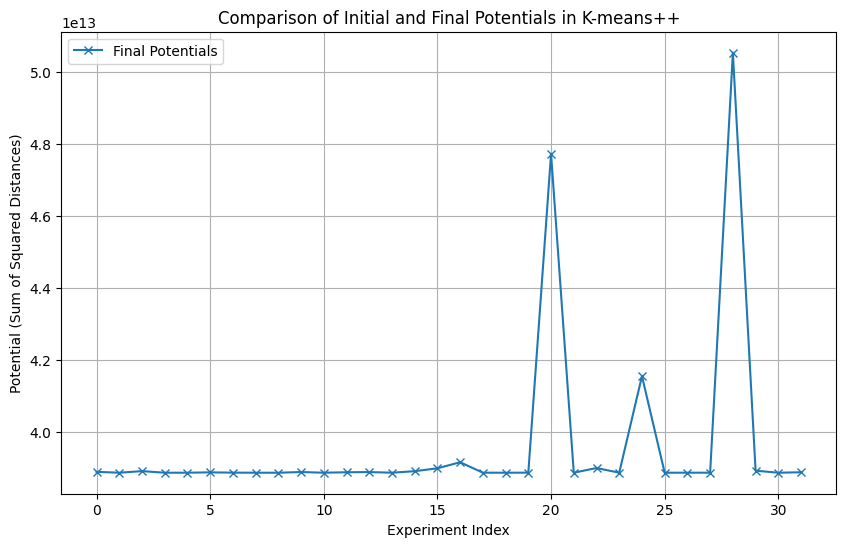

In [31]:
# Plot the comparison of initial and final potentials
plt.figure(figsize=(10, 6))
##plt.plot(range(num_experiments), initial_potentials, label="Initial Potentials", marker='o')
plt.plot(range(num_experiments), final_potentials, label="Final Potentials", marker='x')
plt.xlabel("Experiment Index")
plt.ylabel("Potential (Sum of Squared Distances)")
plt.title("Comparison of Initial and Final Potentials in K-means++")
plt.legend()
plt.grid(True)
plt.show()


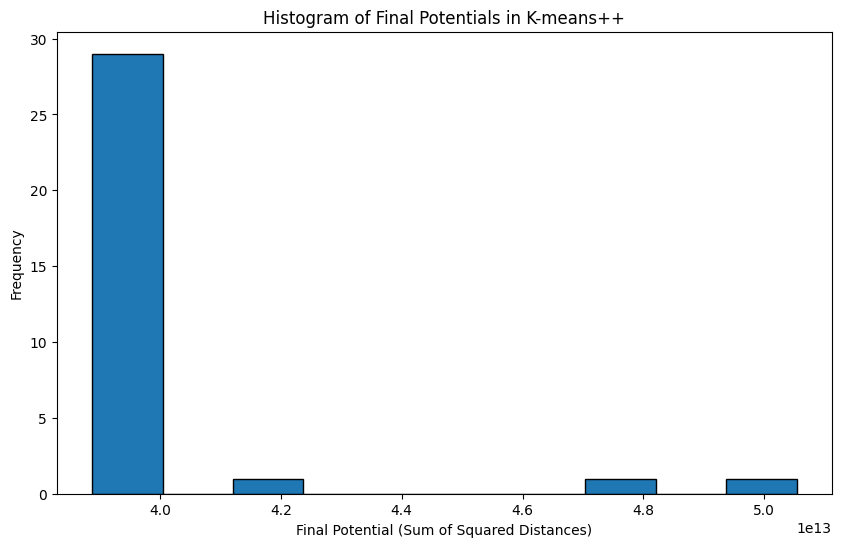

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(final_potentials, bins=10, edgecolor='black')
plt.xlabel("Final Potential (Sum of Squared Distances)")
plt.ylabel("Frequency")
plt.title("Histogram of Final Potentials in K-means++")
##plt.grid(True)
plt.show()